# Layers

This notebook introduces a set of layers commonly found in CNNs:

- Batch Normalization
- Dropout
- Pooling



## References

### Batch Normalization
- Original paper: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
Sergey Ioffe, Christian Szegedy
https://arxiv.org/abs/1502.03167

- Video [Why does Batch Norm work?](https://www.youtube.com/watch?v=nUUqwaxLnWs) Andrew Ng

- Tensorflow: 
tf.keras.layers.BatchNormalization
https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

- [A Gentle Introduction to Batch Normalization for Deep Neural Networks](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)

### Dropout
- Original paper: Improving neural networks by preventing co-adaptation of feature detectors (2012)
G. E. Hinton∗ , N. Srivastava, A. Krizhevsky, I. Sutskever and R. R. Salakhutdinov
https://arxiv.org/pdf/1207.0580.pdf

- More evaluation: Dropout: A Simple Way to Prevent Neural Networks from Overfitting (2014)
Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov
https://jmlr.org/papers/v15/srivastava14a.html

- A Gentler Article: A Gentle Introduction to Dropout for Regularizing Deep Neural Networks (2018)
Jason Brownlee
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

- Another Gentle Article: Understanding And Implementing Dropout In TensorFlow And Keras
Richmond Alake
https://towardsdatascience.com/understanding-and-implementing-dropout-in-tensorflow-and-keras-a8a3a02c1bfa


### Pooling

- Evaluation of Pooling Operations in Convolutional Architectures for Object Recognition
Dominik Scherer, Andreas Muller, and Sven Behnke
http://ais.uni-bonn.de/papers/icann2010_maxpool.pdf

- An alernative to pooling: Striving for Simplicity: The All Convolutional Net, Jost Tobias Springenberg, Alexey Dosovitskiy, Thomas Brox, Martin Riedmiller, https://arxiv.org/abs/1412.6806

- [A Gentle Introduction to Pooling Layers for Convolutional Neural Networks](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)


### General

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    



In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dense, Activation, Flatten, Dropout

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import IPython.display as display

BATCH_SIZE = 32
IMAGE_SIZE = 32

### Auxiliary functions for display purposes only

In [2]:
def show_batch(cols, image_batch, label_batch):

    rows = int(BATCH_SIZE / cols) 
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols
    
    
    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):
        
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)  
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()    
    plt.show()
    
    
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['simple', 'new layers']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.80)
    plt.legend(loc='upper left')
    plt.show()


def show_data(s1,l1, s2,l2, labels):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom = 90)
    plt.legend(loc='upper left')
    plt.show()


    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()
    


### Auxiliary functions to load images

In [3]:
classNames = np.array(['00000','00001', '00002', '00003', '00004', '00005', '00006', '00007'])

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Load images

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_listset = tf.data.Dataset.list_files("C:/Users/obsession/Desktop/Data Augmentation/gtsrb/train_images/*/*.png")
train_set = train_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

val_listset = tf.data.Dataset.list_files("C:/Users/obsession/Desktop/Data Augmentation/gtsrb//val_images/*/*.png")
val_set = val_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

test_listset = tf.data.Dataset.list_files("C:/Users/obsession/Desktop/Data Augmentation/gtsrb//test_images_per_folder/*/*.png")
test_set = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

### Print some data and compute dataset length

In [6]:
for image, label in train_set.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

dataset_length = [i for i,_ in enumerate(train_set)][-1] + 1
print(dataset_length)


Image shape:  (32, 32, 3)
Label:  [False False False False  True False False False]
10200


### Prepare the dataset

In [7]:
train_set = train_set.cache()
train_set = train_set.shuffle(buffer_size=10200)
train_set = train_set.batch(batch_size = BATCH_SIZE)
train_set = train_set.prefetch(buffer_size = AUTOTUNE)
train_set = train_set.repeat()

val_set = val_set.cache()
val_set = val_set.shuffle(buffer_size = 2580)
val_set = val_set.batch(batch_size = BATCH_SIZE)
val_set = val_set.prefetch(buffer_size = AUTOTUNE)
val_set = val_set.repeat()

### Prepare the test set

In [8]:
test_set = test_set.batch(batch_size = BATCH_SIZE)

testset_length = [i for i,_ in enumerate(test_set)][-1] + 1
print('Number of batches: ', testset_length)

Number of batches:  131


## Model I - plain (only Conv layers)

### Definition

In [9]:
def model_I(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), 
                     input_shape=(imgSize, imgSize, channels)
                     ))         
    model.add(LeakyReLU(alpha=0.01))     
                                
    model.add(Conv2D(64, (5, 5) )) 
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5) ) )   
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))             

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model


### Create the models and display stats

In [10]:
modelV1 = model_I(8, 32, 3)

print(modelV1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        102464    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

C:\Users\obsession\anaconda3\envs\DAA\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### Callback definition

 - saving model weights at the best epoch considering validation accuracy
 - early stopping when validation accuracy no longer drops for a number of epochs
 - record session to be available on tensorboard.
    
Go to folder where logs are locatted and call >tensorboard --logdir logs

then open a browser and go to:

http://localhost:6006/    

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

file_pathV1 = 'C:/Users/obsession/Desktop/Data Augmentation/gtsrb/best_modelV1/cp.ckpt'
checkpointerV1 = ModelCheckpoint(filepath= file_pathV1, 
                               monitor = 'val_accuracy',
                               verbose = 1, 
                               save_weights_only=True,
                               save_best_only=True)


earlyStopperV1 = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 8, verbose = 1)

tbCallBackV1 = TensorBoard(log_dir='logV1', histogram_freq=0, write_graph=True, write_images=True)

### Train model

In [14]:
historyV1 = modelV1.fit(train_set, steps_per_epoch = dataset_length/BATCH_SIZE,
          epochs=20, 
          validation_data = val_set, 
          validation_steps= 2580/BATCH_SIZE,
          callbacks=[checkpointerV1, earlyStopperV1, tbCallBackV1 ])

Epoch 1/20
318/318 [==============================] - 5s 17ms/step - loss: 0.2045 - accuracy: 0.9404 - val_loss: 0.3535 - val_accuracy: 0.8888

Epoch 00001: val_accuracy improved from -inf to 0.88876, saving model to C:/Users/obsession/Desktop/Data Augmentation/gtsrb/best_modelV1\cp.ckpt
Epoch 2/20
318/318 [==============================] - 7s 22ms/step - loss: 0.1074 - accuracy: 0.9720 - val_loss: 0.2722 - val_accuracy: 0.9205

Epoch 00002: val_accuracy improved from 0.88876 to 0.92054, saving model to C:/Users/obsession/Desktop/Data Augmentation/gtsrb/best_modelV1\cp.ckpt
Epoch 3/20
318/318 [==============================] - 7s 22ms/step - loss: 0.0633 - accuracy: 0.9844 - val_loss: 0.2841 - val_accuracy: 0.9163

Epoch 00003: val_accuracy did not improve from 0.92054
Epoch 4/20
318/318 [==============================] - 4s 14ms/step - loss: 0.0454 - accuracy: 0.9877 - val_loss: 0.2459 - val_accuracy: 0.9233

Epoch 00004: val_accuracy improved from 0.92054 to 0.92326, saving model to 

### Show graphs for accuracy and loss history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


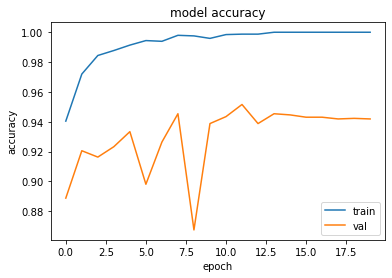

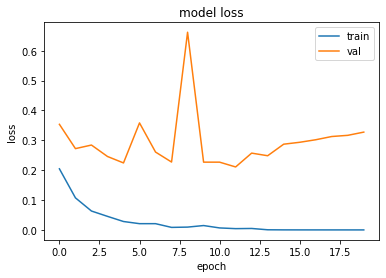

In [15]:
show_history(historyV1)

### Load weights for best epoch and evaluate model

Notice how the validation set accuracy differs from the test set accuracy. Why?

In [16]:
modelV1.load_weights(file_pathV1)
evalV1 = modelV1.evaluate(test_set, verbose=2)
print(evalV1)

valV1 = modelV1.evaluate(val_set, steps= 2580/BATCH_SIZE, verbose=2)

131/131 - 1s - loss: 0.3759 - accuracy: 0.9463
[0.37586715817451477, 0.9462829828262329]
80/80 - 3s - loss: 0.2108 - accuracy: 0.9516
